In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

In [2]:
n_t = 200
n_c, n_s = 10,30
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:3, 0] = [10, 0.1, 0]
A = np.eye(n_s)
A[:3, :3] = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0.5,0,0.5]])
for i in range(J.shape[-1]-1):
    J[:3, i+1] = np.dot(A[:3, :3], J[:3, i])


SC = np.eye(n_s)
SC[:3, :3] = np.array([[1,1,1], [1,1,0],[1,0,1]])
G *= 1e-6


(-5, 200)

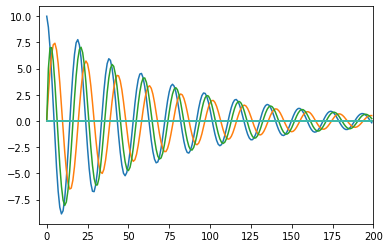

In [3]:
plt.plot(J.T)

plt.xlim(-5, n_t)

In [4]:
m_p = 1
M = np.dot(G, J[:, m_p:])
M *= 1e-6

In [5]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.01, la=[1e-30, 0.5], verbose=1)
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), S_tol=1e-3, normalize=False)
R = cl.coef_

Iteration 0: nbr of active sources 30
Iteration 1: nbr of active sources 16
Iteration 2: nbr of active sources 3
Stopped at iteration 2 : Change in active set tol 3.0000 > 3.0000  


/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3219246521376377e-24, tolerance: 4.374071146732641e-26
  check_random_state(self.random_state), random, self.verbose)


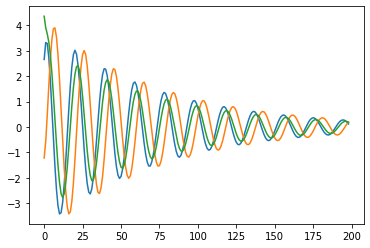

In [6]:
plt.plot(R.T*1e6)

In [7]:
## grid search

In [8]:
gridsearch = {
    'l21_values':[0.01, 0.001, 0.0001, 0.1, 1],
    'la_values':[1e-10, 1e-30],
    'la_ratio_values':[0.5, 1, 0],
    'normalize':[0],
    'model_p':[1]
    }
min(1, 3)

1

In [9]:
cl = ciSDR.eiSDR_cv(**gridsearch)

In [10]:
df = cl.get_opt(G, M, SC)

Successfully created the directory /tmp/tmp_e7fc9aa8-5af4-4cac-9e51-87c94aeab275 


  0%|          | 0/30 [00:00<?, ?it/s]/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9484191309363045e-20, tolerance: 3.896838261872744e-24
  positive)
/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:392: RuntimeWarning: divide by zero encountered in double_scalars
  return rms/(2*n_t*n_c), n, l21s, l1a_l1norm, l1a_l2norm, cl.l21_ratio
  3%|▎         | 1/30 [00:00<00:09,  3.09it/s]/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.525448067088443e-22, tolerance: 3.896838261872744e-24
  positive)
/Users/EEALBRB/workspace/cython_project/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not 

Successfully deleted the directory /tmp/tmp_e7fc9aa8-5af4-4cac-9e51-87c94aeab275


In [11]:
df.Obj.min()

4.011334076159951e-23

In [12]:
df

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
24,2.136231e-24,16,0.000174,62.034642,25.829091,0.0001,1.000000e-30,1.0,1,0,8.506602e-22,4.011334e-23


In [13]:
clf = ciSDR.linear_model.iSDR(l21_ratio=df.ls_reg.values[0], la=[df.la_reg_a.values[0], df.la_reg_r.values[0]], verbose=1)
clf.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), S_tol=1e-3, normalize=0)
R = clf.coef_*1e6

In [14]:
df.ls_reg.values[0]

0.0001

(0, 200)

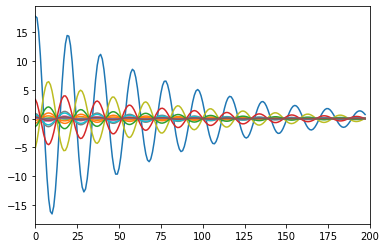

In [15]:
plt.plot(R[:, m_p:].T)
plt.xlim(0, n_t)

In [16]:
df[df.Obj == df.Obj.min()]

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
24,2.136231e-24,16,0.000174,62.034642,25.829091,0.0001,1.000000e-30,1.0,1,0,8.506602e-22,4.011334e-23


In [17]:
cl.results

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
0,1.313721e-24,7,0.000079,620.212282,606.562529,1.0000,1.000000e-30,0.5,1,0,8.506602e-18,3.297626e-20
2,1.725491e-23,3,0.000050,10.107700,4.410362,0.0100,1.000000e-30,0.0,1,0,8.506602e-20,5.560426e-23
3,4.720861e-24,10,0.000130,27.338680,11.160502,0.1000,1.000000e-30,0.5,1,0,8.506602e-19,1.103963e-20
8,6.190490e-24,14,0.000027,375.614008,136.755702,0.0010,1.000000e-30,0.0,1,0,8.506602e-21,5.091884e-23
9,2.873947e-24,15,0.000082,422.172857,185.777690,0.0010,1.000000e-30,1.0,1,0,8.506602e-21,1.593977e-22
11,1.725432e-23,3,0.000050,10.112757,4.412373,0.0100,1.000000e-30,0.5,1,0,8.506602e-20,5.559257e-23
12,1.725367e-23,3,0.000050,10.117481,4.414095,0.0100,1.000000e-30,1.0,1,0,8.506602e-20,5.558127e-23
14,1.389515e-24,7,0.000080,478.978370,464.093010,1.0000,1.000000e-30,0.0,1,0,8.506602e-18,3.345698e-20
16,1.417421e-24,24,0.000152,83.882871,26.253661,0.0001,1.000000e-30,0.5,1,0,8.506602e-22,7.589570e-23
20,1.838900e-24,18,0.000177,163.699048,64.297765,0.0001,1.000000e-30,0.0,1,0,8.506602e-22,5.063000e-23


In [18]:
df

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,Obj
24,2.136231e-24,16,0.000174,62.034642,25.829091,0.0001,1.000000e-30,1.0,1,0,8.506602e-22,4.011334e-23
